In [1]:


# Settings
filename    = '/home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5'
file_format = 'hfd5'
loglevel    = 'DEBUG'
peak_types  = [b's1', b's2', b'unknown', b'noise', b'lone_pulse']

# Import modules
# We get a log file
import logging
log = logging.getLogger('XAMS_analysis')
log.setLevel(loglevel)
# Notebookloader is needed to import ipython notebooks as python modules.
# Notebookloader prompts a warning, but it seems to work fine
# TODO Perhaps we need to reconsider what functions we actually need and put them in a regular python script?
import logging
import NotebookLoader
import Function_definitions as fn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
import h5py
import units
from recarray_tools import append_fields

# Optional progress bar
try:
    from tqdm import tqdm
except ImportError:
    log.debug("You don't have tqdm, I can't give you a nice progress bar...")
    def dummy(*args,**kwargs):
        return args[0]
    tqdm = dummy

##
# Load the data
##
log.debug("Now loading %s (file format=%s)..." % (filename, file_format))

# Slurp peaks and events into memory
# WARNING: For a large dataset, use pax to remove big low-level fields first
# (area_per_channel, does_channel_contribute, does_channel_have_noise)
try:
    # Load the file using pax 3's IO code
    # This supports any format pax can currently produce
    from pax.formats import flat_data_formats
    ioformat = flat_data_formats[file_format]()
    ioformat.open(filename, 'r')
    events = ioformat.read_data('Event')
    peaks = ioformat.read_data('Peak')
    ioformat.close()
   
except ImportError:
    log.debug("You don't have pax 3 installed, falling back to HDF5-specific code...")
    import h5py
    f = h5py.File(filename)
    events = f.get('Event')[:]
    peaks = f.get('Peak')[:]
    f.close()

log.info("Loaded %s, containing %d peaks (%0.2f MB RAM) and %d events (%0.2f MB RAM)" % (
    filename, len(peaks), peaks.nbytes/10**6, len(events), events.nbytes/10**6))
if len(events) == 0:
    raise ValueError("You don't have any events in this dataset!")


# WORK IN PROGRESS (EH)
# Loop over peaks and redefine the classification
# TODO get this to work
# # At the moment, we just use the default from the processer
# s1_cut    = (peaks['type'] == b's1')
# s2_cut    = (peaks['type'] == b's2')
# other_cut = np.logical_not(s1_cut | s2_cut)

# #peaks = append_fields(peaks,'true_type',np.zeros([len(peaks)],dtype=np.str))

# n_peaks = len(peaks)
# n_s1_before = len(peaks[peaks['type'] == b's1'])

# for pk in peaks:
#     if pk['type'] == b's1':
#         pk['true_type'] = 's1'
    
# peaks[s2_cut]['type']
# log.debug('Before reclassification: %.2f%% of the peaks is an S1' % (n_s1_before/n_peaks*100))


# Append fields to the event and peak list. Only the ones that can be directly determined from the events lists

# full range: the total time of the peak.
peaks = append_fields(peaks, 'full_width', (peaks['right'] - peaks['left'] + 1)*fn.dt)
peaks = append_fields(peaks,'mid',peaks['left']*fn.dt + 0.5* peaks['full_width'])

# Recalculate area fraction top because of wrong ordering of PMTs
peaks['area_fraction_top'] = peaks['area_per_channel'][:,3] / peaks['area']

# Group peaks by event
peaks_per_event = fn.group_by(peaks, 'Event')
#assert len(peaks_per_event) == len(events) # Raise error if false

# Add total number of peaks
events = append_fields(events,
                       'n_peaks',
                       np.array([len(x) for x in peaks_per_event]))

# Add number of individual peak types
for pt in peak_types:
    events = append_fields(events,
                           'n_'+pt.decode(),
                           np.array([len(x[x['type'] == pt]) for x in peaks_per_event]))
# Add number of BIG peaks (mainly S2 is important). Use to cut pileup / double scatters    
    events = append_fields(events,
                           'n_big_'+pt.decode(),
                           np.array([len(x[(x['type'] == pt) & (x['area'] >= 100)]) for x in peaks_per_event]))


##
# Select events with >=1 S1 and >=1 S2
# Necessary step for next cell
##
n_before = len(events)
cut = (events['n_s1'] >= 1) & (events['n_s2'] >= 1)
events = events[cut]
peaks_per_event = [x for i, x in enumerate(peaks_per_event) if cut[i]]

log.debug("%0.2f%% of events have >=1 S1 and S2, keeping only those." % (100*len(events)/n_before))
if((100*len(events)/n_before)<50):
    log.warning("Only %0.2f%% of events have >=1 S1 and S2, keeping only those." % (100*len(events)/n_before))
    

##
# Add s1_... and s2_... fields to event
# This way you can access all properties of the main S1 and S2 directly from the event
# TODO add peak area per channel
##
ignore_fields = ['Event', 'Peak', 'type',
                 # recfunctions have trouble with subarrays...
                 'does_channel_contribute', 'does_channel_have_noise', 'area_per_channel']
for pt in (b's1', b's2'):
    main_peaks = []
    for pks in tqdm(peaks_per_event, desc='Selecting %ss' % pt.decode()):
        peaks_of_this_type =  pks[pks['type'] == pt]
        main_peaks.append(
            peaks_of_this_type[
                np.argmax(
                   peaks_of_this_type['area']
                )
            ])
    main_peaks = np.array(main_peaks)
    assert len(main_peaks) == len(peaks_per_event)

    # Add s1_... and s2_... fields
    for fn in main_peaks.dtype.names:
        if fn in ignore_fields:
            continue
        events = append_fields(events,
                               "%s_%s" % (pt.decode(), fn),
                               main_peaks[fn])
        
if(len(peaks[peaks['detector']==b'NaI']) > 0):
    log.debug('Found external NaI, will add those properties!')
    main_peaks = []
    for pks in tqdm(peaks_per_event, desc='Selecting NaI pulses'):
        peaks_of_this_type =  pks[pks['detector'] == b'NaI']
        main_peaks.append(
            peaks_of_this_type[
                np.argmax(
                   peaks_of_this_type['area']
                )
            ])
    main_peaks = np.array(main_peaks)
    assert len(main_peaks) == len(peaks_per_event)

    # Add NaI_... fields
    for fn in main_peaks.dtype.names:
        if fn in ignore_fields:
            continue
        events = append_fields(events,
                               "NaI_%s" % fn ,
                               main_peaks[fn])
else:
   log.debug('No NaI found, so just TPC channels added.')

# Add drift time
events = append_fields(events, 'drift_time', events['s2_hit_time_mean'] - events['s1_hit_time_mean'])
# Drift time is here from hit time mean to hit time mean. Its the mean of the hit maximum weighted by area.
# This DOES introduce a constant, but it's probably a very stable quantity.

/home/axel/anaconda3/lib/python3.4/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)
DEBUG:XAMS_analysis:Now loading /home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5 (file format=hfd5)...


importing IPython notebook from Function_definitions.ipynb


KeyError: 'hfd5'

In [ ]:
############## CURVE FITTING FOR R7M15 ##############
cut = ((events['drift_time'] > 20* units.us) & (events['drift_time'] <30* units.us) & 
       (events['s2_area_fraction_top']>0.52) & (events['n_big_s2']<2) &
       ((events['s2_area'] + 55 * events['s1_area'] )>35000)
      )

ph_sel = ((events['drift_time'] > 23* units.us) & (events['drift_time'] <31* units.us) & 
       (events['s2_area_fraction_top']>0.52) & (events['n_big_s2']<2) &
       ((events['s2_area'] + 55 * events['s1_area'] )>35000)
      )

ph_com_sel = ((events['drift_time'] > 23* units.us) & (events['drift_time'] <31* units.us) & 
       (events['s2_area_fraction_top']>0.52) & (events['n_big_s2']<2) )
# http://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

In [2]:
from matplotlib.colors import LogNorm
from pylab import *
import scipy.optimize as opt

plt.figure(figsize=(10,7))
binsize = 40
s1s2hist = plt.hist2d(events[cut]['s1_area'], events[cut]['s2_area'], bins=binsize,
                      range = [[200,500],[20000,30000]])#, norm=LogNorm())
plt.colorbar()
plt.show()


NameError: name 'events' is not defined

In [4]:
# hist_counts: binsize x binsize array of number of counts
# s1 / s2: binsize+1 array of edges

hist_counts = s1s2hist[0]
hist_s1     = s1s2hist[1]
hist_s2     = s1s2hist[2]

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_s1[i+1]+hist_s1[i])/2
           for i in range(len(hist_s1)-1)]
y_fit_1d =[(hist_s2[i+1]+hist_s2[i])/2
           for i in range(len(hist_s2)-1)]

x_fit = np.array([x_fit_1d 
    for i in range(len(y_fit_1d))])

y_fit = np.array([y_fit_1d 
    for i in range(len(x_fit_1d))])

# Test to get the formatting right
x_flat = []
y_flat = []
z_flat = []

for i_y in range(len(y_fit_1d)):
    for i_x in range(len(x_fit_1d)):
        x_flat.append(x_fit_1d[i_x])
        y_flat.append(y_fit_1d[i_y])
        z_flat.append(hist_counts[i_x,i_y])

# Check for if you dont trust this code
you_dont_trust_this_code = False
if you_dont_trust_this_code:    
    plt.figure(figsize=(10,7))
    plt.scatter(x_flat,y_flat,c=z_flat)
    s1s2hist = plt.hist2d(events[cut]['s1_area'], events[cut]['s2_area'], bins=binsize,
                          range = [[200,500],[20000,30000]])#, norm=LogNorm())
    plt.show()

In [5]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g #.ravel()

In [6]:
#(amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
initial_guess = (20,350,24000,30,2000,-0.03,0)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x_flat, y_flat), z_flat, p0=initial_guess)
print(popt)

[  6.16453416e+01   3.31248201e+02   2.50978610e+04   3.27594878e+01
   2.05518440e+03  -1.04247359e-02   1.02543647e+00]


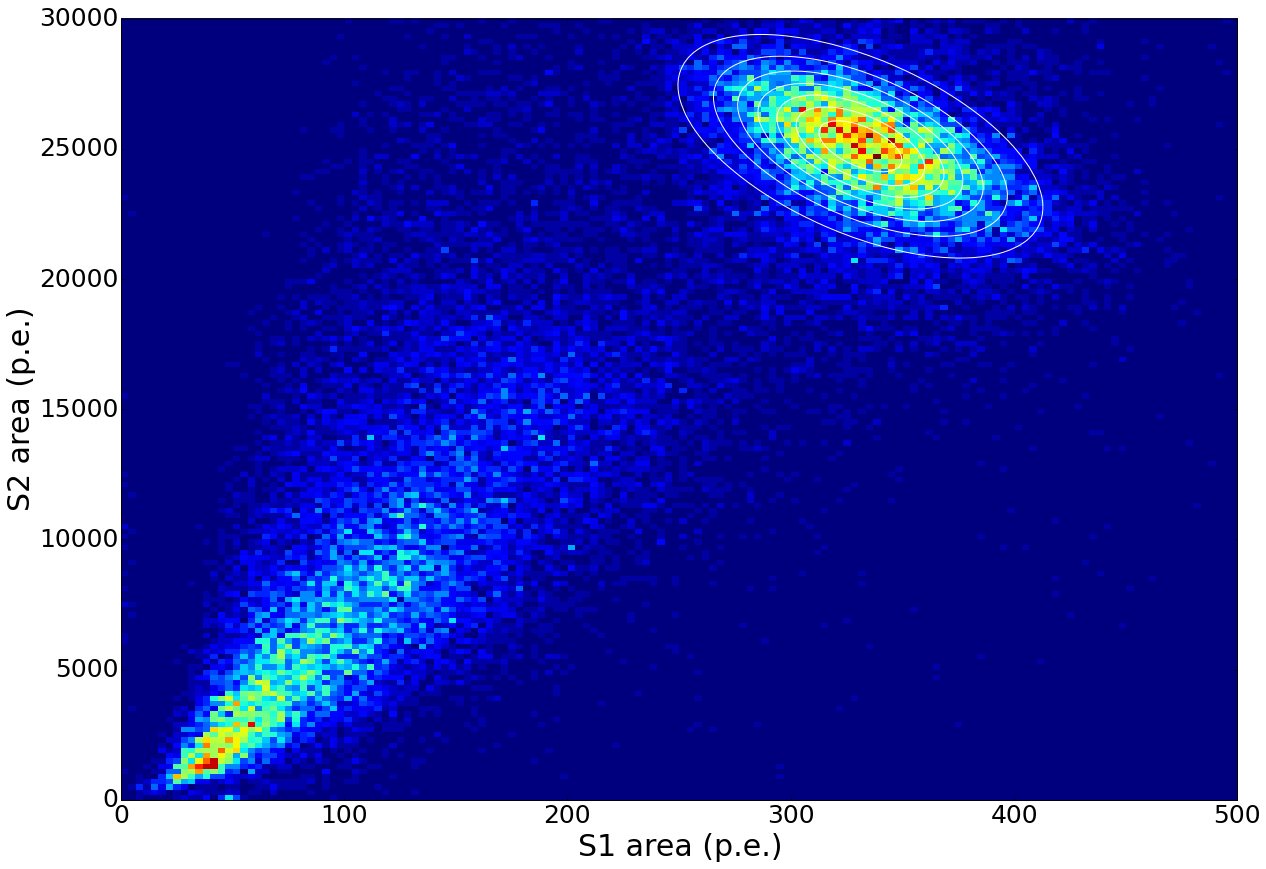

In [10]:
binsize = 150
# NOTE the following lines actually mean: loop over x within loop of y. 
# Thanks Python, just cost me 2 hours of my life


plt.figure(figsize=(20,14))
#fig, ax = plt.subplots(1, 1)
#ax.hold(True)
s1s2hist = plt.hist2d(events[ph_com_sel]['s1_area'], events[ph_com_sel]['s2_area'], bins=binsize,range = [[0,500],[0,30000]])#, norm=LogNorm())
hist_s1     = s1s2hist[1]
hist_s2     = s1s2hist[2]
# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_s1[i+1]+hist_s1[i])/2
           for i in range(len(hist_s1)-1)]
y_fit_1d =[(hist_s2[i+1]+hist_s2[i])/2
           for i in range(len(hist_s2)-1)]
data_fitted = np.array([twoD_Gaussian((x, y), *popt)
            for y in y_fit_1d
                for x in x_fit_1d]).flatten()

plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(binsize,binsize), 8,colors='w')
plt.xlabel('S1 area (p.e.)',fontsize=30)
plt.ylabel('S2 area (p.e.)',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.tick_params(axis='both', which='minor', labelsize=25)
plt.show()
#ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max())), colors='b')


ValueError: total size of new array must be unchanged

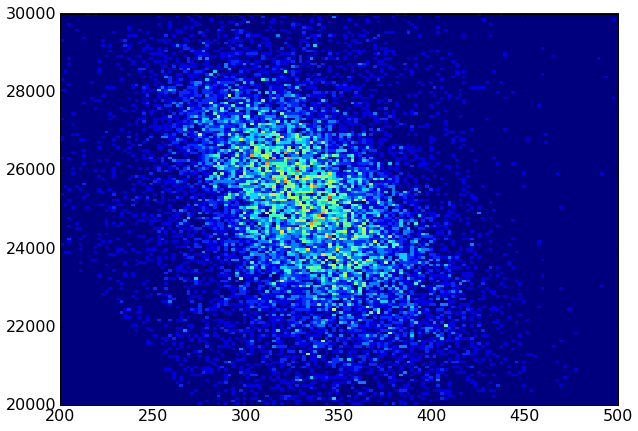

In [9]:
# NOTE the following lines actually mean: loop over x within loop of y. 
# Thanks Python, just cost me 2 hours of my life
data_fitted = np.array([twoD_Gaussian((x, y), *popt)
            for y in y_fit_1d
                for x in x_fit_1d]).flatten()


plt.figure(figsize=(10,7))
#fig, ax = plt.subplots(1, 1)
ax.hold(True)
s1s2hist = plt.hist2d(events[cut]['s1_area'], events[cut]['s2_area'], bins=binsize,range = [[200,500],[20000,30000]])#, norm=LogNorm())

plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(40,40), 8,colors='w')
plt.xlabel('S1 area (p.e.)')
plt.ylabel('S2 area (p.e.)')
plt.show()
#ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max())), colors='b')

In [10]:
def twoD_Gaussian_proper(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, rho, offset):
    '''http://en.wikipedia.org/wiki/Multivariate_normal_distribution#Normally_distributed_and_independent'''
    
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)
    sigma_x = float(sigma_x)
    sigma_y = float(sigma_y)
    
    a = 1/(2*(1-rho**2)) * 1/(sigma_x**2)
    b = 1/(2*(1-rho**2)) * 1/(sigma_y**2)
    c = 1/(2*(1-rho**2)) * 1/(sigma_x*sigma_y) * 2*rho
    
    
    g = offset + amplitude * np.exp(-a*(x-xo)**2 - b*(y-yo)**2 - c*(x-xo)*(y-yo))

    return g.ravel()

In [11]:
#(amplitude, xo, yo, sigma_x, sigma_y, rho, offset)
initial_guess = (20.,350.,24000.,30.,2000.,-0.03,0.)

popt, pcov = opt.curve_fit(twoD_Gaussian_proper, (x_flat, y_flat), z_flat, p0=initial_guess)
print(popt)

[  6.16451982e+01   3.31248188e+02   2.50978559e+04   3.91417155e+01
   2.05507979e+03   5.47211791e-01   1.02539852e+00]


ValueError: total size of new array must be unchanged

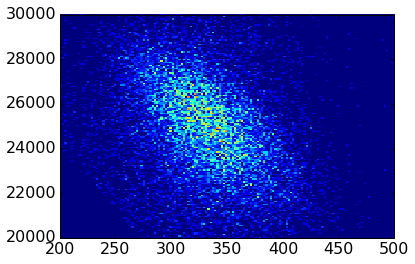

In [12]:
initial_guess = (20.,330.,25000.,30.,2000.,-0.5,0.)

data_fitted = np.array([twoD_Gaussian_proper((x, y), *popt)
                for x in x_fit_1d
                       for y in y_fit_1d]).flatten()

fig, ax = plt.subplots(1, 1)
ax.hold(True)
s1s2hist = plt.hist2d(events[cut]['s1_area'], events[cut]['s2_area'], bins=binsize,range = [[200,500],[20000,30000]])#, norm=LogNorm())
plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(40,40), 8,colors='w')
plt.colorbar()
plt.show()
#ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max())), colors='b')


In [13]:
popt

array([  6.16451982e+01,   3.31248188e+02,   2.50978559e+04,
         3.91417155e+01,   2.05507979e+03,   5.47211791e-01,
         1.02539852e+00])

In [14]:
theta =0.01
scale_to = 1.

# Compute stuff
s1_rot = (events[compton_plus_photo_selection]['s1_area']*np.cos(theta) + 
          events[compton_plus_photo_selection]['s2_area']*np.sin(theta) )
s1     = events[compton_plus_photo_selection]['s1_area']

s1_rot_avg = np.average(events[cut]['s1_area']*np.cos(theta) + 
                      events[cut]['s2_area']*np.sin(theta) )
s1_avg     = np.average(events[cut]['s1_area'])

s1_rot = s1_rot/s1_rot_avg*scale_to
s1     = s1/s1_avg*scale_to


hist1d = plt.hist(s1_rot,bins = 200,histtype='step',range=(0,1.5))
plt.show()

NameError: name 'compton_plus_photo_selection' is not defined

In [15]:
theta_list = [0,math.pi/2,0.01066,0.0175]
labels     = ['S1','S2','Combined fit','Combined best res']
colors     = ['g','r', 'b', 'orange']
theta_list = theta_list [::-1]
labels     = labels[::-1]
colors     = colors[::-1]
scale_to   = 511.

s1_rot_list = []

for theta in theta_list:
    s1_rot = (events[compton_plus_photo_selection]['s1_area']*np.cos(theta) + 
          events[compton_plus_photo_selection]['s2_area']*np.sin(theta) )
    s1_rot_avg = np.average(events[cut]['s1_area']*np.cos(theta) + 
                          events[cut]['s2_area']*np.sin(theta) )
    s1_rot = s1_rot/s1_rot_avg*scale_to
    s1_rot_list.append(s1_rot)

NameError: name 'compton_plus_photo_selection' is not defined

ValueError: x must have at least one data point

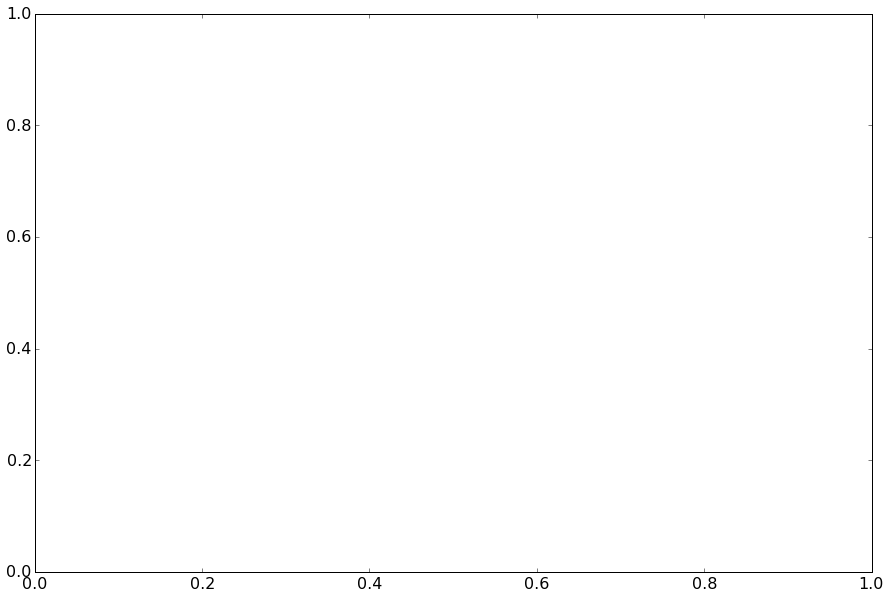

In [16]:
plt.figure(figsize=(15,10))
plt.hist(s1_rot_list,bins = 200,histtype='step',range=(0,800),label=labels,color=colors)
plt.xlim(0,800)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [17]:
maximum = np.max(hist1d[0])
print(maximum)
for i in range(len(hist1d[0])):
    if hist1d[0][i] > 0.5*maximum:
        print(hist1d[1][i])
        break
        
print(i)
for j in range(i+5,len(hist1d[0])):
    if hist1d[0][j] < 0.5*maximum:
        print(hist1d[1][j])
        break

NameError: name 'hist1d' is not defined

In [18]:
baljjewbflasen = range(10,len(hist1d[0]))
print(baljjewbflasen)

NameError: name 'hist1d' is not defined